Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn (42).csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  

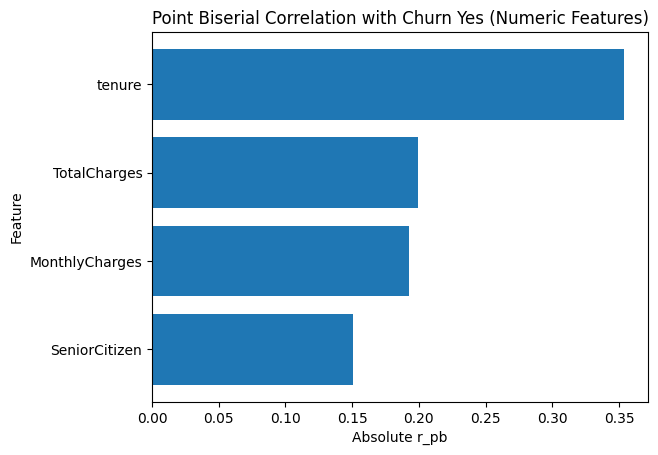

Accuracy : 0.8038379530916845
Precision: 0.6475903614457831
Recall   : 0.5748663101604278
F1-score : 0.6090651558073654
ROC-AUC  : 0.7308019837346185
Confusion Matrix:
 [[916 117]
 [159 215]]
Random Forest Result:
Accuracy: 0.7896233120113717
Precision: 0.6258064516129033
Recall: 0.5187165775401069
F1: 0.5672514619883041
ROC AUC Score: 0.703211144529976
Confusion Matrix: [[917 116]
 [180 194]]
XGBoost Result:
Accuracy: 0.7782515991471215
Precision: 0.5890804597701149
Recall: 0.5481283422459893
F1: 0.5678670360110804
ROC AUC Score: 0.7048482950339336
Confusion Matrix:
 [[890 143]
 [169 205]]
Tuned Logistic Regression Result:
Accuracy : 0.7263681592039801
Precision: 0.49093904448105435
Recall   : 0.7967914438502673
F1-score : 0.6075433231396534
ROC-AUC  : 0.7488313463200998
Confusion Matrix:
 [[724 309]
 [ 76 298]]
Tuned Random Forest Result:
Accuracy : 0.7668798862828714
Precision: 0.5444015444015444
Recall   : 0.7540106951871658
F1-score : 0.6322869955156951
ROC-AUC  : 0.76277495069135

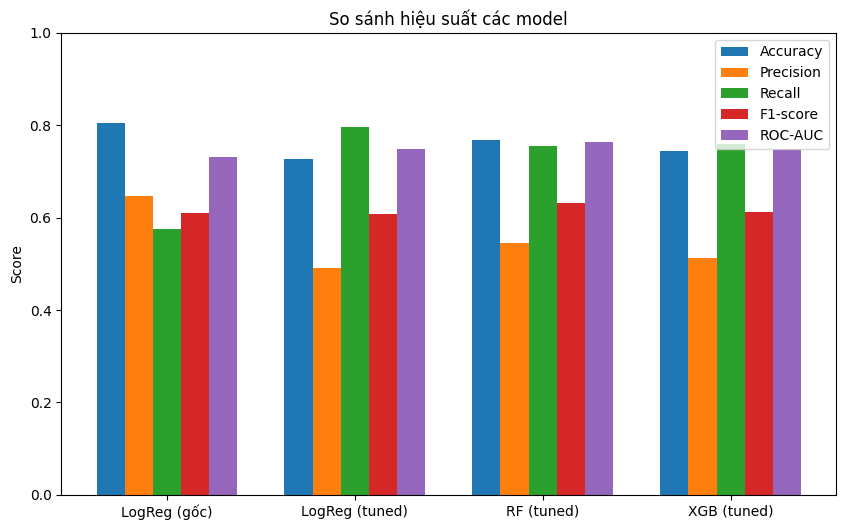

In [ ]:
from google.colab import files
uploaded = files.upload()
import pandas as pd
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()
df.info()
df.shape
df.isnull().sum()

# Vì biến TotalCharge nhìn sơ trong dataset là dạng số nhưng ở đây Dtype là Object nên ta cần tìm hiểu nguyên nhân & xử lý
df['TotalCharges'].unique()
# Vì Có thể có một số giá trị chuỗi trắng (' '), chuỗi rỗng hoặc khoảng trắng mà .unique() chưa hiện rõ vì số lượng giá trị rất lớn (7043 dòng) nên tìm hướng khác
import numpy as np
df['TotalCharges'] = df['TotalCharges'].str.strip().replace("", np.nan)
df['TotalCharges'] = df['TotalCharges'].astype(float)
df['TotalCharges'].isnull().sum()
df.info()

# Giờ tìm các cột có Dtype là Object để chuyển hóa thành one-hot encoding
categorical_cols = df.select_dtypes(include = 'object').columns.tolist()
categorical_cols.remove('customerID')
for col in categorical_cols:
  print(col)
  print(df[col].nunique())

# Sau khi biết các cột có Dtype object này chỉ có dưới 4 category --> tha hồ xài one hot encoding
df_encoded = pd.get_dummies(df, columns = categorical_cols, drop_first=True)
df_encoded.shape
df_encoded.info()

# Loại biến customerID vì thường không dùng trong phân tích dự đoán vì nó không chứa thông tin giúp phân loại khách hàng
df_encoded = df_encoded.drop('customerID', axis = 1)
df_encoded.columns
df_encoded['Churn_Yes'].value_counts(dropna=False)

# Trước khi tính point biserial, ta cần đổi True → 1 và False → 0 để tính toán thuận tiện
df_encoded['Churn_Yes'] = df_encoded['Churn_Yes'].astype(int)

# Kiểm tra Monthly Charges xem có thiếu giá trị nào không, nếu có phải xử lý mới đi tiếp được
df['MonthlyCharges'].isna().sum()

# Giờ Tính point biserial cho MonthlyCharges ↔ Churn_Yes
from scipy.stats import pointbiserialr
r, p = pointbiserialr(df_encoded['Churn_Yes'], df['MonthlyCharges'])
print("r_pb =", r, "| p value =", p)

# Do kết quả trên, mức ảnh hưởng chỉ ở mức nhẹ, cần xem xét các biến khác. Giờ đến Tenure
r, p = pointbiserialr(df_encoded['Churn_Yes'], df_encoded['tenure'])
print("r_pb =", r, "| p value =", p)

# Giờ đến Total Charges
df['TotalCharges'].isna().sum()
df_encoded = df_encoded.dropna(subset=['TotalCharges'])
r, p = pointbiserialr(df_encoded['Churn_Yes'], df_encoded['TotalCharges'])
print("r_pb =", r, "| p value =", p)

# Lọc ra tất cả các cột có kiểu dữ liệu là số (numeric)
df_encoded.select_dtypes(include=[np.number]).columns
num_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

# Giờ Tính point biserial cho từng cột trong num_cols
result = []
for col in num_cols:
  mask = df_encoded[col].notna() & df_encoded['Churn_Yes'].notna()
  r, p = pointbiserialr(df_encoded.loc[mask, 'Churn_Yes'], df_encoded.loc[mask, col])
  result.append((col, r, p))
result

# Chuyển list kết quả thành bảng & xếp hạng
pb_df = pd.DataFrame(result, columns=['feature', 'r_pb', 'p value'])
pb_df['abs_r'] = pb_df['r_pb'].abs()
pb_df = pb_df.sort_values('abs_r', ascending=False)

# Vẽ biểu đồ
import matplotlib.pyplot as plt
plt.barh(pb_df['feature'], pb_df['abs_r'])
plt.xlabel('Absolute r_pb')
plt.ylabel('Feature')
plt.title('Point Biserial Correlation with Churn Yes (Numeric Features)')
plt.gca().invert_yaxis()
plt.show()

# Nãy là numeric features, giờ quất luôn phân tích categorical features.
cat_cols = df_encoded.select_dtypes(exclude=[np.number]).columns
cat_cols
import scipy.stats as ss
import numpy as np
def cramers_v(x, y):
  confusion_matrix = pd.crosstab(x, y)
  chi2 = ss.chi2_contingency(confusion_matrix)[0]
  n = confusion_matrix.sum().sum()
  phi2 = chi2 / n
  r, k = confusion_matrix.shape
  return np.sqrt(phi2 / (min(k - 1, r - 1)))
result_cat = []
for col in cat_cols:
  r = cramers_v(df_encoded['Churn_Yes'], df_encoded[col])
  result_cat.append((col, r))
cat_df = pd.DataFrame(result_cat, columns=['feature', 'cramers_v'])
cat_df = cat_df.sort_values('cramers_v', ascending=False)
cat_df

# Gộp hai bảng ranking này thành Feature Priority List
num_df = pd.DataFrame(result, columns=['feature', 'score', 'p value'])
num_df['abs_score'] = num_df['score'].abs()
num_df['type'] = 'numeric'
cat_df = pd.DataFrame(result_cat, columns=['feature', 'score'])
cat_df['abs_score'] = cat_df['score'].abs()
cat_df['type'] = 'categorical'
all_features_df = pd.concat([num_df[['feature', 'score', 'abs_score', 'type']], cat_df[['feature', 'score', 'abs_score', 'type']]], ignore_index=True)
all_features_df = all_features_df.sort_values('abs_score', ascending=False)
all_features_df

# Giờ chạy mô hình
y = df_encoded['Churn_Yes']
X = df_encoded.drop(columns=['Churn_Yes'])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=2000, solver='saga')
log_reg.fit(X_train_scaled, y_train)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
y_pred = log_reg.predict(X_test_scaled)
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))
print("ROC-AUC  :", roc_auc_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Chuyển qua Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print("Random Forest Result:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1:", f1_score(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_rf))
print("Confusion Matrix:", confusion_matrix(y_test, y_pred_rf))

# Chuyển qua XG Boost do Logistics Regression vẫn đang hơn Random Forest
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
xgb_clf = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
print("XGBoost Result:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1:", f1_score(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

#Tuning Logistics Regression do nó vẫn thắng 2 model kia
from sklearn.linear_model import LogisticRegression
log_reg_tuned = LogisticRegression(
    max_iter=3000,
    solver='saga',
    class_weight='balanced',
    C=2.0,
    random_state=42
)
log_reg_tuned.fit(X_train_scaled, y_train)
y_pred_tuned = log_reg_tuned.predict(X_test_scaled)
print("Tuned Logistic Regression Result:")
print("Accuracy :", accuracy_score(y_test, y_pred_tuned))
print("Precision:", precision_score(y_test, y_pred_tuned))
print("Recall   :", recall_score(y_test, y_pred_tuned))
print("F1-score :", f1_score(y_test, y_pred_tuned))
print("ROC-AUC  :", roc_auc_score(y_test, y_pred_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))

# Tuning Random Forest do Logistics Regression tuning xong còn dở hơn cái gốc
from sklearn.ensemble import RandomForestClassifier
rf_tuned = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)
rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = rf_tuned.predict(X_test)
print("Tuned Random Forest Result:")
print("Accuracy :", accuracy_score(y_test, y_pred_rf_tuned))
print("Precision:", precision_score(y_test, y_pred_rf_tuned))
print("Recall   :", recall_score(y_test, y_pred_rf_tuned))
print("F1-score :", f1_score(y_test, y_pred_rf_tuned))
print("ROC-AUC  :", roc_auc_score(y_test, y_pred_rf_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_tuned))

# Tuning XGBoost luôn
from xgboost import XGBClassifier

xgb_tuned = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    random_state=42,
    eval_metric='logloss'
)

xgb_tuned.fit(X_train, y_train)

y_pred_xgb_tuned = xgb_tuned.predict(X_test)

print("Tuned XGBoost Result:")
print("Accuracy :", accuracy_score(y_test, y_pred_xgb_tuned))
print("Precision:", precision_score(y_test, y_pred_xgb_tuned))
print("Recall   :", recall_score(y_test, y_pred_xgb_tuned))
print("F1-score :", f1_score(y_test, y_pred_xgb_tuned))
print("ROC-AUC  :", roc_auc_score(y_test, y_pred_xgb_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb_tuned))

# Vẽ biểu đồ trực quan
import matplotlib.pyplot as plt
import numpy as np

# Tên model và các chỉ số
models = ['LogReg (gốc)', 'LogReg (tuned)', 'RF (tuned)', 'XGB (tuned)']
accuracy = [0.8038, 0.7264, 0.7669, 0.7441]
precision = [0.6476, 0.4909, 0.5444, 0.5126]
recall = [0.5749, 0.7968, 0.7540, 0.7594]
f1 = [0.6091, 0.6075, 0.6323, 0.6121]
roc_auc = [0.7308, 0.7488, 0.7628, 0.7490]

x = np.arange(len(models))
width = 0.15

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - 2*width, accuracy, width, label='Accuracy')
ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1, width, label='F1-score')
ax.bar(x + 2*width, roc_auc, width, label='ROC-AUC')

ax.set_ylabel('Score')
ax.set_title('So sánh hiệu suất các model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
plt.ylim(0, 1)
plt.show()

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contr

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy Score_LR: 0.6955287437899219
Precision Score_LR: 0.4583963691376702
Recall Score_LR: 0.8101604278074866
F1 Score_LR: 0.5855072463768116
ROC AUC Score_LR: 0.813164897052365


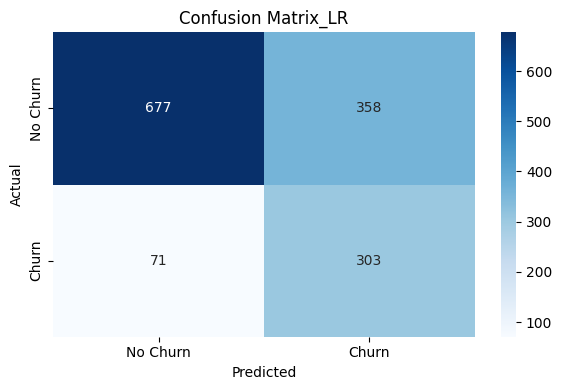

              precision    recall  f1-score   support

    No churn      0.905     0.654     0.759      1035
       Churn      0.458     0.810     0.586       374

    accuracy                          0.696      1409
   macro avg      0.682     0.732     0.672      1409
weighted avg      0.787     0.696     0.713      1409



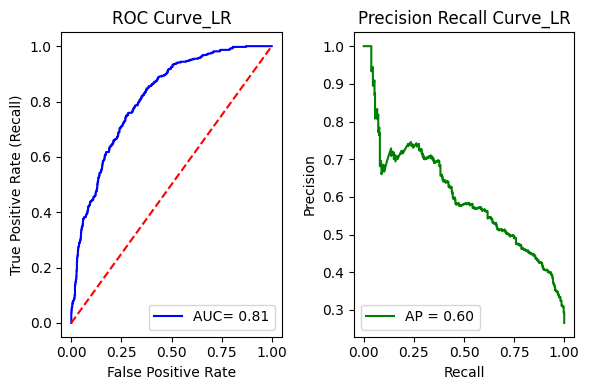

Accuracy Score_RF: 0.7842441447835344
Precision Score_RF: 0.6206896551724138
Recall Score_RF: 0.48128342245989303
F1 Score_RF: 0.5421686746987951
ROC AUC Score_RF: 0.8232374899894082


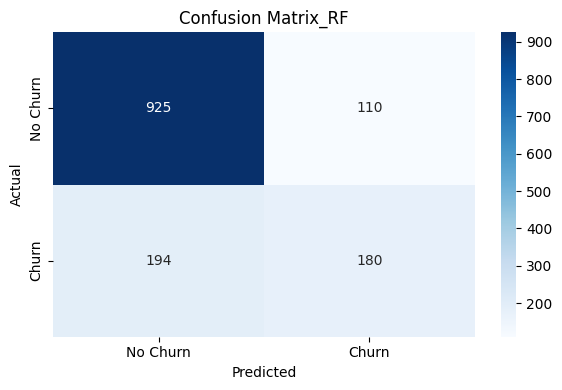

              precision    recall  f1-score   support

    No churn      0.827     0.894     0.859      1035
       Churn      0.621     0.481     0.542       374

    accuracy                          0.784      1409
   macro avg      0.724     0.688     0.701      1409
weighted avg      0.772     0.784     0.775      1409



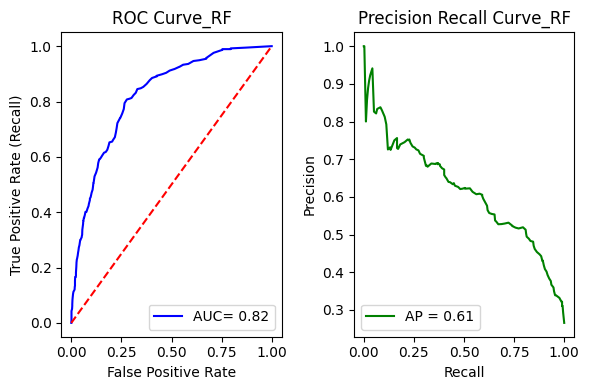

Accuracy Score_XGB: 0.8005677785663591
Precision Score_XGB: 0.6514657980456026
Recall Score_XGB: 0.5347593582887701
F1 Score_XGB: 0.5873715124816447
ROC AUC Score_XGB: 0.8393112712805807


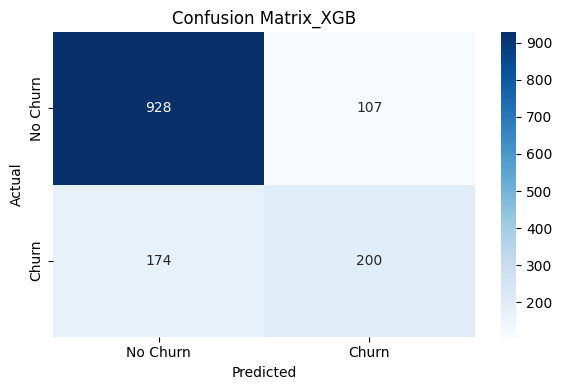

              precision    recall  f1-score   support

    No churn      0.842     0.897     0.869      1035
       Churn      0.651     0.535     0.587       374

    accuracy                          0.801      1409
   macro avg      0.747     0.716     0.728      1409
weighted avg      0.792     0.801     0.794      1409



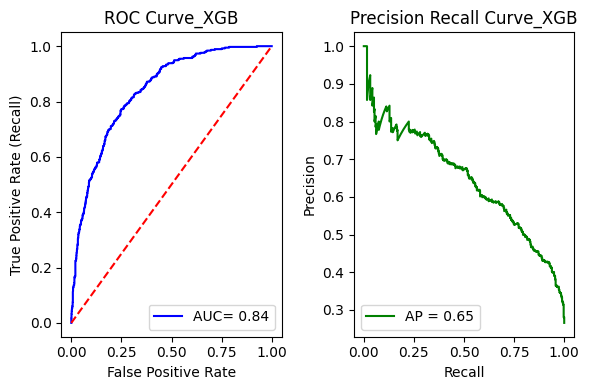

In [1]:
from google.colab import files
upload = files.upload()
import pandas as pd
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv', low_memory=False)

# Basic EDA
df.shape
df.info()
df.describe()
df.isnull().sum()
df.head()

# Actions before Basic EDA
## Change dtype of "TotalCharges" column from object to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors= 'coerce')
df.isnull().sum()
df.isna().sum()
## Fill 11 nulls in "TotalCharges" column
df['TotalCharges'] = df['TotalCharges'].fillna(0)
df.isnull().sum()
df.isna().sum()
df.info()

# Outlier Check for 03 numeric columns: tenure, MonthlyCharges, TotalCharges
## Tenure
min_val_tenure = df['tenure'].min()
max_val_tenure = df['tenure'].max()
Q1_tenure = df['tenure'].quantile(0.25)
Q3_tenure = df['tenure'].quantile(0.75)
IQR_tenure = Q3_tenure - Q1_tenure
lower_bound_tenure = Q1_tenure - IQR_tenure * 1.5
upper_bound_tenure = Q3_tenure + IQR_tenure * 1.5
outlier_pct_tenure = ((df['tenure'] < lower_bound_tenure) | (df['tenure'] > upper_bound_tenure)).mean()*100
## MonthlyCharges
min_val_MonthlyCharges = df['MonthlyCharges'].min()
max_val_MonthlyCharges = df['MonthlyCharges'].max()
Q1_MonthlyCharges = df['MonthlyCharges'].quantile(0.25)
Q3_MonthlyCharges = df['MonthlyCharges'].quantile(0.75)
IQR_MonthlyCharges = Q3_MonthlyCharges - Q1_MonthlyCharges
lower_bound_MonthlyCharges = Q1_MonthlyCharges - 1.5 * IQR_MonthlyCharges
upper_bound_MonthlyCharges = Q3_MonthlyCharges + 1.5 * IQR_MonthlyCharges
outlier_pct_MonthlyCharges = ((df['MonthlyCharges'] < lower_bound_MonthlyCharges) | (df['MonthlyCharges'] > upper_bound_MonthlyCharges)).mean()*100
## TotalCharges
min_val_TotalCharges = df['TotalCharges'].min()
max_val_TotalCharges = df['TotalCharges'].max()
Q1_TotalCharges = df['TotalCharges'].quantile(0.25)
Q3_TotalCharges = df['TotalCharges'].quantile(0.75)
IQR_TotalCharges = Q3_TotalCharges - Q1_TotalCharges
lower_bound_TotalCharges = Q1_TotalCharges - 1.5 * IQR_TotalCharges
upper_bound_TotalCharges = Q3_TotalCharges + 1.5 * IQR_TotalCharges
outlier_pct_TotalCharges = ((df['TotalCharges'] < lower_bound_TotalCharges) | (df['TotalCharges'] > upper_bound_TotalCharges)).mean()*100

# Predictive Analysis Setup
## One-hot encoding
### For Binary cols: Partner, Dependents, PhoneService, PaperlessBilling, Churn, gender
df['Partner'] = df['Partner'].map({'Yes': 1, 'No': 0})
df['Dependents'] = df['Dependents'].map({'Yes': 1, 'No': 0})
df['PhoneService'] = df['PhoneService'].map({'Yes': 1, 'No': 0})
df['PaperlessBilling'] = df['PaperlessBilling'].map({'Yes': 1, 'No': 0})
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
### For others columns: MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaymentMethod
df = pd.get_dummies(df, columns= ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'], drop_first= True)
df.info()

## Drop non-predictive value columns: customerID
df = df.drop('customerID', axis= 1)
df.columns

## Last set-up stage
### Define target column (y) & input columns (x)
y = df['Churn']
x = df.drop('Churn', axis= 1)
### Train/Test Split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 42, stratify= y)

# Modeling
## Logistics Regression
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(penalty= 'l2', solver= 'saga', max_iter= 1000, class_weight= 'balanced', C= 1.0, random_state= 42)
lr_model.fit(x_train, y_train)
y_pred = lr_model.predict(x_test)
y_prob = lr_model.predict_proba(x_test)[:,1]
## Logistics Regression's Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc, average_precision_score
print('Accuracy Score_LR:', accuracy_score(y_test, y_pred))
print('Precision Score_LR:', precision_score (y_test, y_pred))
print('Recall Score_LR:', recall_score(y_test, y_pred))
print('F1 Score_LR:', f1_score(y_test, y_pred))
print('ROC AUC Score_LR:', roc_auc_score(y_test, y_prob))

import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot= True, fmt= 'd', cmap= 'Blues', xticklabels= ['No Churn', 'Churn'], yticklabels= ['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix_LR')
plt.tight_layout()
plt.show()

print(classification_report(y_test, y_pred, target_names=['No churn','Churn'], digits=3, zero_division=0))

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
prec, rec, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (6, 4))
ax1.plot(fpr, tpr, color='blue', label=f'AUC= {roc_auc:.2f}')
ax1.plot([0,1],[0,1], color='red', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate (Recall)')
ax1.set_title('ROC Curve_LR')
ax1.legend(loc='lower right')
ax2.plot(rec, prec, color='green', label=f'AP = {ap:.2f}')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision Recall Curve_LR')
ax2.legend(loc='lower left')
plt.tight_layout()
plt.show()

## Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators= 100, max_depth= None, min_samples_split= 2, min_samples_leaf= 1, max_features= 'sqrt', class_weight= None, random_state= 42, n_jobs= -1)
rf_model.fit(x_train, y_train)
y_pred= rf_model.predict(x_test)
y_prob= rf_model.predict_proba(x_test)[:,1]
## Random Forest Classifier's Evaluation
print('Accuracy Score_RF:', accuracy_score(y_test, y_pred))
print('Precision Score_RF:', precision_score (y_test, y_pred))
print('Recall Score_RF:', recall_score(y_test, y_pred))
print('F1 Score_RF:', f1_score(y_test, y_pred))
print('ROC AUC Score_RF:', roc_auc_score(y_test, y_prob))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot= True, fmt= 'd', cmap= 'Blues', xticklabels= ['No Churn', 'Churn'], yticklabels= ['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix_RF')
plt.tight_layout()
plt.show()

print(classification_report(y_test, y_pred, target_names=['No churn','Churn'], digits=3, zero_division=0))

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
prec, rec, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (6, 4))
ax1.plot(fpr, tpr, color='blue', label=f'AUC= {roc_auc:.2f}')
ax1.plot([0,1],[0,1], color='red', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate (Recall)')
ax1.set_title('ROC Curve_RF')
ax1.legend(loc='lower right')
ax2.plot(rec, prec, color='green', label=f'AP = {ap:.2f}')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision Recall Curve_RF')
ax2.legend(loc='lower left')
plt.tight_layout()
plt.show()

## XGBoost
from xgboost import XGBClassifier
xgb_model = XGBClassifier(n_estimators= 100, learning_rate= 0.1, max_depth= 6, subsample= 0.8, colsample_bytree= 1.0, scale_pos_weight= 1, random_state= 42, eval_metric= 'logloss', n_jobs= -1, tree_method= 'hist')
xgb_model.fit(x_train, y_train)
y_pred = xgb_model.predict(x_test)
y_prob = xgb_model.predict_proba(x_test)[:,1]
## XGBoost's Evaluation
print('Accuracy Score_XGB:', accuracy_score(y_test, y_pred))
print('Precision Score_XGB:', precision_score (y_test, y_pred))
print('Recall Score_XGB:', recall_score(y_test, y_pred))
print('F1 Score_XGB:', f1_score(y_test, y_pred))
print('ROC AUC Score_XGB:', roc_auc_score(y_test, y_prob))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot= True, fmt= 'd', cmap= 'Blues', xticklabels= ['No Churn', 'Churn'], yticklabels= ['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix_XGB')
plt.tight_layout()
plt.show()

print(classification_report(y_test, y_pred, target_names=['No churn','Churn'], digits=3, zero_division=0))

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
prec, rec, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (6, 4))
ax1.plot(fpr, tpr, color='blue', label=f'AUC= {roc_auc:.2f}')
ax1.plot([0,1],[0,1], color='red', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate (Recall)')
ax1.set_title('ROC Curve_XGB')
ax1.legend(loc='lower right')
ax2.plot(rec, prec, color='green', label=f'AP = {ap:.2f}')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision Recall Curve_XGB')
ax2.legend(loc='lower left')
plt.tight_layout()
plt.show()